**YOUR NAMES HERE**

Spring 2020

CS443: Computational Neuroscience

Project 2: Content Addressable Memory

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import preprocessing
from PIL import Image
import random

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Task 3) Hopfield network

In this task, you will implement and analyze a Hopfield network — a recurrent neural network with content addressable memory. You will use Hebbian learning learn weights that imprint the training data as "memories" that can be recalled with an incomplete and/or distorted version of the training data.

### 3a. Load in image data

- Load in the training set, three color photographs of natural scenes with varying resolution: `train_img_1.png`, `train_img_2.png`, and `train_img_3.png`.
    - *Note that the docstrings/test code in the next tasks assumes that you load in the images as PIL Image objects. You may deviate from this if you prefer a different way to handle this, but note that your binarized feature vectors should look reasonable at the end of Task 3c and be consistent with the shape/type/value test code there.*

In [2]:
train1 = Image.open('data/train_img_1.png')
train2 = Image.open('data/train_img_2.png')
train3 = Image.open('data/train_img_3.png')

### 3b. Consistently resize images

Right now, your images have different spatial resolutions. You should resize them so that they are 128x128 grayscale images.

- In `preprocessing.py`, implement `resize_imgs`.
- Resize the training images below to make them consistently sized and grayscale so that they can be placed in a single ndarray (`shape=(3, 128, 128)`).
- Write code inside `row_plot` below then create a 1x3 row showing all the images side-by-side.

In [14]:
imgs = [train1,train2,train3]
#imgs= preprocessing.resize_imgs(imgs, 128,128)
imgs= preprocessing.resize_imgs(imgs, 64,64) #changed to 64x64 for speed 

In [15]:
def row_plot(imgs, title, cmap='bone', sz=(12, 4)):
    '''Plots images in `imgs` in a single row
        
    Parameters:
    -----------
    imgs: ndarray. shape=(N, Iy, Ix)x
        Images to display in the row.
    title: str. Title for entire figure.
    cmap: str. Matplotlib color scale to use when plotting.
        Some good options are "bone" for binary and "grayscale" for grayscale images.
    sz: tuple. Format=(fig_width, fig_height). Size of the entire plot figure.
    
    TODO:
    - Generate the row of images, making sure you set the figure size and color scheme.
    - Label each image with its index in `imgs` (e.g. 0, 1, 2)
    '''
#     plt.figure(figsize=sz) 
    N = len(imgs)
    fig, axes = plt.subplots(nrows=1, ncols=N, figsize=sz)
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(title)
    for i in range(N):
# plt.subplot() #shape=(N, Iy, Ix)
        axes[i].imshow(imgs[i]) 
        axes[i].set_title("Image Index:" + str(i) ) 
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        #axes[i].set_axis('off') 
    plt.show()

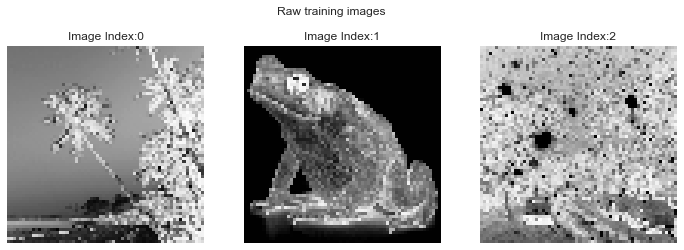

In [16]:
row_plot(imgs, 'Raw training images', cmap='gray')

### 3c. Preprocess images into bipolar feature vectors

Hopfield networks assume that inputs are 1D feature vectors of binary values. In this subtask, you will do the preprocessing to get the images encoded as binary feature vectors. While this can be done by representing values as `[0, 1]`, it is more common to use **bipolar vectors** with either [-1, +1] components. *One extension idea is to investigate why bipolar vectors are preferred over ordinary 0/1 binary.*

For example, before training a Hopfield network, you might flatten and binarize an image, then encode its pixel values as `[-1, +1, -1, -1, -1,...]`.

In `preprocessing.py`, implement the following functions:
- `img2binaryvectors`: Converts grayscale images into bipolar feature vectors.
- `vec2img`: Inflates a binary feature vector back into its (width, height) dimensions so that it can be plotted/visualized.
- In the cell below, show your preprocessed binary images in a row.

In [17]:
# Preprocess here
print(imgs.shape)
imgs_pp= preprocessing.img2binaryvectors(imgs) 
print(f'After preprocessing, image data shape: {imgs_pp.shape}, dtype: {imgs_pp.dtype}, Unique values: {np.unique(imgs_pp)}')
print('You should see:\nAfter preprocessing, image data shape: (3, 16384), dtype: int64, Unique values: [-1  1]')

(3, 64, 64)
normData (3, 64, 64)
normData0  3
normData1  (64, 64)
After preprocessing, image data shape: (3, 4096), dtype: float64, Unique values: [-1.  1.]
You should see:
After preprocessing, image data shape: (3, 16384), dtype: int64, Unique values: [-1  1]


(3, 4096)


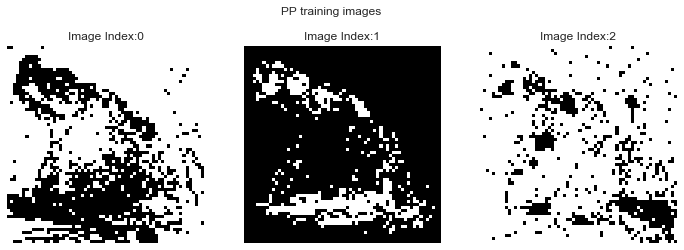

In [19]:
# Plot here
#plotimgs = preprocessing.vec2img(imgs_pp, 128, 128)
plotimgs = preprocessing.vec2img(imgs_pp, 64, 64) #changed to 64x64 for speed 
print(imgs_pp.shape)
row_plot(plotimgs, 'PP training images', cmap='gray')

### 3d. Implement and train your Hopfield net. Use it to recall training images.

Implement the following methods in `hopfield.py`. Note that there is test code below.
- Constructor: Initializes things, including the weights via `initialize_wts`.
- `initialize_wts`: Use Hebbian learning to generate each neuron's connectivity weights based on all the training data. The Hebbian weight equation is: $$w_{n,m} = \sum_{i=1}^N \vec{I}_{i}^T \vec{I}_{i}$$ where $i$ indexes the $i^{th}$ 1D input feature vector $I$. This equation holds if $i \neq j$. If $i = j$, then $w_{n,m} = 0$ (along main diagonal).
- `energy`: Compute the energy of the current state of the network: $$E = -\frac{1}{2} \sum_{n} \sum_{m} y_n w_{n,m} y_m$$ where $\vec{y}$ is the 1D `net_act` at each index $n$ and $m$ and $w_{n,m}$ is the weight between the corresponding neurons.
- `predict`: Use test images to have the network generate (recall) the 'closest' image in memory (from training set). In this subtask, the test set is the training set (i.e. prompt recall of a memory with the memory). Activation of neurons is done **asychronously** — the `net_act` of only a random subset of neurons are updated at each time step. Equation for updating the `net_act` at each time step $t$:
$$y_{i}(t) = \text{sgn} \left ( \sum_{j=1}^M w_{ij}y_j \right )$$
Above, $\text{sgn} (x)$ is the sign function (+1 if $x > 0$, 0 if $x = 0$, -1 if $x < 0$), $i$ are all indices in the list `inds` of randomly selected neurons to update on timestep $t$.

In [20]:
from hopfield import HopfieldNet

#### Test constructor and `initialize_wts`

In the cell below:
- Create a Hopfield net and train it on the N=3 training images.
- Check your weights with the test code below.
    - *Note: if your wts mismatch those below, that could just mean that you preprocessed the dataset a little differently. However, you should still have numbers in the interval [-1, +1].*

In [21]:
#test random pattern 
np.random.seed(0)
test_rand_n, test_rand_m = 3, 4
rand_data = np.random.random(size=(test_rand_n, test_rand_m))
rand_net = HopfieldNet(rand_data, orig_width=2, orig_height=2)
print(f'Your weights are:\n{rand_net.wts} and should be:')
print('[[0.    0.345 0.426 0.396]\n [0.345 0.    0.339 0.389]\n [0.426 0.339 0.    0.379]\n [0.396 0.389 0.379 0.   ]]')

Your weights are:
[[0.    0.345 0.426 0.396]
 [0.345 0.    0.339 0.389]
 [0.426 0.339 0.    0.379]
 [0.396 0.389 0.379 0.   ]] and should be:
[[0.    0.345 0.426 0.396]
 [0.345 0.    0.339 0.389]
 [0.426 0.339 0.    0.379]
 [0.396 0.389 0.379 0.   ]]


In [22]:
# Create hopfield net here
net = HopfieldNet(imgs_pp, orig_width= 2, orig_height=2)

print(f'Your wts have shape {net.wts.shape}. Should be (16384, 16384)')
print(f'Your wts have these min/max values {net.wts.min()}/{net.wts.max()}. Should be -1.0/1.0.\n')
print(f'1st few wts are:\n{net.wts[0,:5]} and should be\n[0. 1. 1. 1. 1.]')
print(f'Last few wts are:\n{net.wts[-1,-5:]} and should be\n[1. 1. 1. 1. 0.]\n')
print(f'Is your wt matrix symmetric? {np.allclose(net.wts, net.wts.T)}')

Your wts have shape (4096, 4096). Should be (16384, 16384)
Your wts have these min/max values -1.0/1.0. Should be -1.0/1.0.

1st few wts are:
[0.    1.    0.333 0.333 0.333] and should be
[0. 1. 1. 1. 1.]
Last few wts are:
[0.333 0.333 1.    0.333 0.   ] and should be
[1. 1. 1. 1. 0.]

Is your wt matrix symmetric? True


#### Test `energy`

NOTE: `imgs_pp` represents the preprocessed bipolar vectors. Substitute your own variable name.

In [12]:
np.random.seed(1)
test_M = 100
test_net_act = np.random.choice([-1, 1], size=test_M)
net.wts = np.random.choice([-1, 1], size=(test_M, test_M))
print(f'The network energy with the test random pattern is {net.energy(test_net_act):.2f} and should be -14.00.')

The network energy with the test random pattern is -14.00 and should be -14.00.


#### Test `predict`: Recall trained image

In [38]:
preds = net.predict(imgs, update_frac=0.1, verbose=False, show_dynamics=True)

running
looping through samples
energy hist < 2
num samps:  3
numCells:  1
netAct:  (64, 64)
wts:  (4096, 4096)
wts[:,inds]:  (4096,)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4096 is different from 64)

### 3e. Accuracy of memory

Now that you have your recalled memories, check to see how faithfully they represent the training data.

- In `preprocessing.py`, implement the `recall_error` function to measure how different the network's recalled memory is from the corresponding trained image. 

In [24]:
print(f'Recovered image error rates: {preprocessing.recall_error(imgs_pp[np.arange(len(imgs))], preds)}')

Recovered image error rates: 1.0


**Question 1:** How accurately does the Hopfield network recall the N=3 images when training set = test set?

**Answer 1:** The net recalls images with 100% accuracy when the training and test sets are equal. 

#check thid once prdict is debugged

### 3f. Plot recalled memories

- Fill in the function `plot_data_and_recalled` that will plot each original image and recalled memory side-by-side in the same row.
- In the cell below, call the function on your test case when train = test. 

In [25]:
def plot_data_and_recalled(data, recalled, maxRows=5, cmap='bone', sz=(4, 10)):
    '''Plot a grid of images where corresponding `data` and `recalled` images are in
    the same row side-by-side.
    
    Parameters:
    -----------
    data: ndarray. shape=(N, Iy, Ix)
        Original images used to train network
    recalled: ndarray. shape=(N, Iy, Ix)
        Recalled images generatedd from the train network
    maxRows: int. Limit the number of rows to this number.
    cmap: str. Matplotlib color scale to use when plotting.
        Some good options are "bone" for binary and "grayscale" for grayscale images.
    sz: tuple. Format=(fig_width, fig_height). Size of the entire plot figure.
    
    TODO:
    - Generate the row of images, making sure you set the color scheme.
    - Label the columns "data" and "recalled"
    '''
    
    #code copied from above plot function
    N = len(imgs)
    fig, axes = plt.subplots(nrows=2, ncols=N, figsize=sz)
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(title)
    for i in range(N):
        axes[i].imshow(imgs[i]) 
        axes[i].set_title("Image Index:" + str(i) ) 
        axes[i].set_xticks([])
        axes[i].set_yticks([]) 
    plt.show()

In [ ]:
# Plot training images next to recalled images when train == test

### 3g. Noisy data

Below, write code that mirrors what you did with Fuzzy ART:

- Train the network on the same images but prompt the network to recall memories when you insert 10% random noise to each test image (10% of binary values are flipped in each image). 
- Plot the TEST (noisy) and recalled images side-by-side.

**Question 2:** How accurately does the Hopfield network recall the N=3 images when the test images are noisy?

**Question 3:** In your own words, describe how the network is doing this.

**Answer 2:** 

**Answer 3:** 

In [ ]:
# create initial binary noise mask
ten_percent = int(n_rows*n_cols*0.1)
mask_list = (ten_percent * [-1]) + (((n_rows*n_cols)-ten_percent) * [1])
mask = np.array(mask_list)
mask_test = np.copy(mask)

# for each digit, add 10% noise to the image
for i in range(n_digits):
    np.random.shuffle(mask_test)
    mask_vis = np.reshape(mask_test, (n_rows, n_cols))
    data_vis[i] = data_vis[i]*mask_vis
    data_test[i] = data_test[i]*mask_test

### 3h. Missing data

Below, write code that mirrors what you did with Fuzzy ART:

- Train the network on the same images but prompt the network to recall memories where half of the pixels are set to -1 (if plotted, the bottom half of each image). 
- Plot the TEST (with half data missing) and recalled images side-by-side.

**Question 4:** How accurately does the Hopfield network recall the N=3 images when the test images have missing information?

**Question 5:** In your own words, describe how the network is doing this.

**Answer 4:** 

**Answer 5:** 

In [ ]:
noisy_digits_test = np.concatenate(noisy_digits_test[:, :int(n_rows*n_cols*0.5)], np.zeros(n_rows*n_cols-int(n_rows*n_cols*0.5)))
noisy_digits_vis = np.reshape(noisy_digits_test, (n_rows, n_cols))

## Task 4) Hopfield network storage capacity

In this task, you will explore the storage properties of Hopfield networks.

### 4a. Digits dataset

- In the cell below, load in the digits dataset (`digits.txt`). There are 10 digits in total (N=10), each occupies 7 rows and 9 columns of the text file. The digits are represented as 1s and the background pixels are 0s. Ultimately, format the data in bipolar format in two ndarrays: one for visualization (`shape=(10, 7, 9)`) and the other for training the data (`shape=(10, 63)`).
- Make a row plot showing the preprocessed data. 

In [ ]:
n_digits = 10
n_rows  = 7
n_cols = 9

# Import, preprocess, and plot digits ultimately as ndarrays
# Import, preprocess, and plot digits ultimately as ndarrays  

# load binary digit data
with open("data/digits.txt") as f:
    content = f.read()
    
digits = np.array([int(char) for line in content.split('\n') for char in line])
digits = np.where(digits==0, -1, digits)

# create dataframe digits for visualization and training
digits_vis = digits.reshape((n_digits, n_rows, n_cols))
digits_train = digits.reshape((n_digits, n_rows*n_cols))

# plot the digits
row_plot(digits_vis, 'Raw training digit images', cmap='gray')

### 4b. Capacity experiments

- Create the test set: noisy versions of the digits (10% noise should be fine).
- Train a Hopfield network multiple times, starting with only one digit (e.g. 0). Test on the noisy version of the same digit. Then train/test on 2 digits, etc. You are looking for a qualitative change in the accuracy/ouputs of the Hopfield network. Before you're sure that you've found it, try increasing `update_frac` to see if that helps.
- Below, create two`plot_data_and_recalled` plots: before and after the critical change.

**Question 6:** Describe what happens before and after the critical change. 

**Question 7:** At what training size did the critical change happen?

**Question 8:** Decribe what is happening with respect to the data and memory storage of the network and why. Be detailed in your answer. *Hint: Think about the weights and the differences in inputs within this dataset.*

**Answer 6:** 

**Answer 7:** 

**Answer 8:**

In [ ]:
# create initial binary noise mask
ten_percent = int(n_rows*n_cols*0.1)
mask_list = (ten_percent * [-1]) + (((n_rows*n_cols)-ten_percent) * [1])
mask = np.array(mask_list)
mask_test = np.copy(mask)

# copy over digits
noisy_digits_vis = np.copy(digits_vis)
noisy_digits_test = np.copy(digits_train)


# for each digit, add 10% noise to the image
for i in range(n_digits):
    np.random.shuffle(mask_test)
    mask_vis = np.reshape(mask_test, (n_rows, n_cols))
    noisy_digits_vis[i] = noisy_digits_vis[i]*mask_vis
    noisy_digits_test[i] = noisy_digits_test[i]*mask_test

row_plot(digits_vis, 'original images', cmap='gray')
row_plot(noisy_digits_vis, 'noisy images', cmap='gray')

## Extensions

### 1) Binary vs. bipolar feature representations

### 2) Run experiments on any of the CAM networks with your own images to address a hypothesis that you have

- Don't just run another image dataset through the models. Have a hypothesis in mind (please state it) and run tests and analyze the results informed by this hypothesis (did you support or invalidate it?). 

### 3) Non-image data

- CAM models work on lots of different types of data, not just images. For example, you could train the models on DNA nucleotide sequences (e.g. strings of ACGT). To do this, you could encode DNA sequences as concatenated length 4 one-hot vectors (there are only 4 possible base pairs), then run experiments like checking to see if the trained network can detect the closest sequence to a test sequence with a mutation (1+ letters ommitted/subsituted/etc).

### 4) Implement and compare with other CAM networks

- There are other networks with similar architectures as Hopfield networks, such as brain-state-in-a-box (and generalized brain-state-in-a-box) and bidirectional associative memory (*there is a dynamic network version, different from the matrix based algorithm covered in class*). Research a network, report on its differences, implement it, test out / compare capcity, CAM recall, etc.
    - Boltzmann machines (and restricted boltzmann machines) are in this category, though they probably are too large of an undertaking for an extension!

### 5) Maximizing storage capacity

- Even visually simple bipolar images actually have a high degree of feature redundancy that makes memory storage more challenging for Hopfield networks. Train and test recall on orthogonal and nearly-orthogonal feature vectors (i.e. those with controlled levels of "noise" or "corruption"). How many patterns can you accurately store?